In [16]:
import os
import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy.signal import butter, filtfilt

import matplotlib.pyplot as plt

EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'

trial = 3
channel = 'F7'

# Util Methods

## Visualize the data

### Spikes Visualization

In [17]:
EEG_SPIKES = f'{EEG_FOLDER}/EEG_spikes'

def load_preprocessed_spikes(trial, channel):
    def append_zeros_to_fix_size(filename, size=6):
        # remove .npz
        filename = filename[:-4]
        filename = ('0' * (size-len(filename))) + filename
        return filename

    resonators_dir = f'{EEG_SPIKES}/{trial}/{channel}'
    return {
        append_zeros_to_fix_size(f0):
            np.load(f'{resonators_dir}/{clk_freq}/{f0}')['spikes'].astype(np.int8)
        for clk_freq in os.listdir(resonators_dir)
        for f0 in os.listdir(f'{resonators_dir}/{clk_freq}')
    }


def spikes_to_bins(spikes, window=195_000):
    num_bins = (len(spikes) // window) + 1
    bins = np.zeros(num_bins, dtype=np.int32)
    for j in range(num_bins):
        bins[j] = np.sum(spikes[j*window:(j+1)*window])
    return bins


def all_spikes2bins(full_spikes_data, window=195_000):
    return {
        f0: spikes_to_bins(spikes, window)
        for f0, spikes in full_spikes_data.items()
    }


def normalize_arr(arr):
    # return arr
    return (arr-min(arr))/(max(arr)-min(arr))


def spikes_data2eeg_bands(spikes_data):
    print(len(normalize_arr(spikes_data['40.791'])))
    print(max(normalize_arr(spikes_data['40.791'])))
    print(min(normalize_arr(spikes_data['40.791'])))
    return {
        # '0. Delta': sum(normalize_arr(spikes_data[f])
        #                      for f in ['00.657', '01.523', '02.120', '02.504', '03.490']) / 5,
        '1. Theta': sum(normalize_arr(spikes_data[f])
                             for f in ['04.604', '05.755', '06.791', '08.000']) / 4,
        '2. Alpha': sum(normalize_arr(spikes_data[f])
                             for f in ['08.058', '09.065', '10.072', '11.885', '14.000']) / 5,
        '3. Beta':  sum(normalize_arr(spikes_data[f])
                             for f in ['15.108', '17.266', '19.424', '21.583', '25.468']) / 5,
        '4. Gamma': sum(normalize_arr(spikes_data[f])
                             # for f in ['36.259', '40.791', '45.324', '53.482', '63.000']) / 5
                             for f in ['36.259', '40.791']) / 2
    }


def normalize_columns(arr):
    """
    Normalizes each column of a 2D NumPy array so that the minimum value in each column is 0 and the maximum is 1.

    Args:
    - arr: A 2D NumPy array with shape (n, k).

    Returns:
    - A normalized version of arr with the same shape.
    """
    # Find the minimum and maximum values for each column
    col_mins = np.min(arr, axis=0)
    col_maxs = np.max(arr, axis=0)

    # Make sure there are no divisions by zero
    col_ranges = np.where(col_maxs == col_mins, 1, col_maxs - col_mins)

    # Normalize each column by subtracting its minimum and dividing by its range
    return (arr - col_mins) / col_ranges

def spikes_dict2spectogram(
        output_spikes,
):
    spikes_heatmap = pd.DataFrame.from_dict(output_spikes)
    spikes_heatmap = spikes_heatmap.reindex(sorted(spikes_heatmap.columns), axis=1).T
    spikes_heatmap_data = spikes_heatmap.to_numpy()

    spikes_heatmap_data = spikes_heatmap_data
    return normalize_columns(spikes_heatmap_data)

def plot_heatmap(heatmap_data, y_labels, annotate, title=None):
    fig, ax = plt.subplots(figsize=(14, 5))
    im = ax.imshow(
        heatmap_data,
        cmap='jet',
        aspect='auto',
        origin='lower',
        vmin=np.min(heatmap_data),
        vmax=np.max(heatmap_data),
    )
    ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)

    # Loop over data dimensions and create text annotations.
    if annotate:
        for i in range(len(heatmap_data)):
            for j in range(len(heatmap_data[i])):
                text = ax.text(j, i,  f'{heatmap_data[i, j]:.4f}',
                               rotation=90,
                               ha="center", va="center", color="white")

    if title:
        ax.set_title(title)
    fig.tight_layout()
    fig.colorbar(im, ax=ax, label='Interactive colorbar')
    plt.show()

In [18]:
example_spikes_channel = load_preprocessed_spikes(trial, channel)

5
1.0
0.0


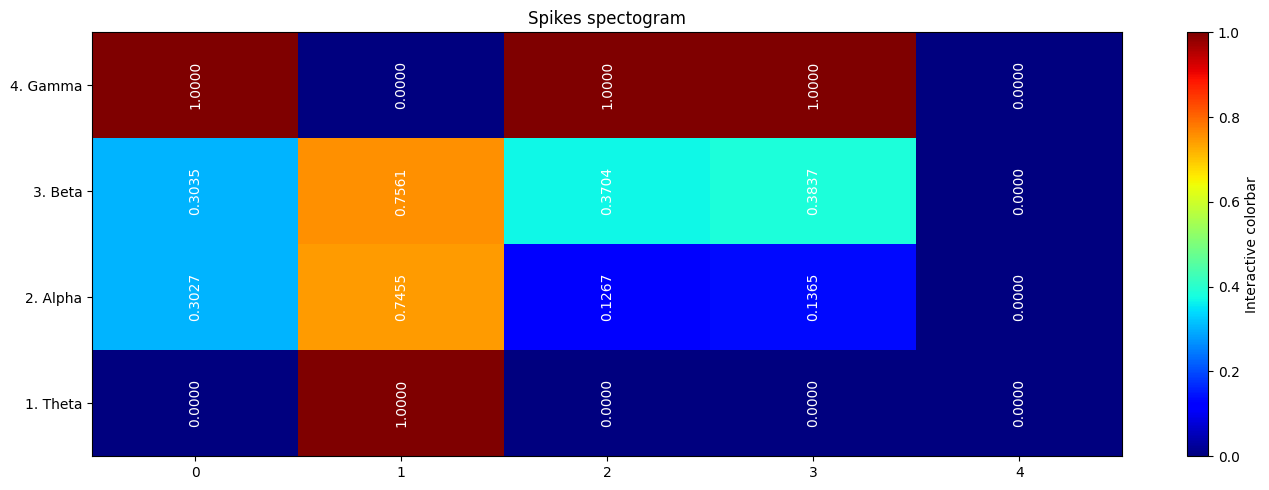

In [19]:
eeg_bands = spikes_data2eeg_bands(all_spikes2bins(example_spikes_channel, window=5_000_000))
spikes_spectogram = spikes_dict2spectogram(eeg_bands)
bins=int(spikes_spectogram.shape[1])
plot_heatmap(spikes_spectogram, eeg_bands.keys(), annotate=True, title='Spikes spectogram')

 ### FFT Visualize

In [20]:
data_root = f'{EEG_FOLDER}/EEG_Data'


def plot_spectrogram(data, fs, fmin, fmax):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=256, Fs=fs,
                                         noverlap=128, cmap='jet')
    print(bins)
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # plt.title(channel + f' Spectrogram {channel_name}({fmin} - {fmax}) Hz')
    plt.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
               vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
    plt.colorbar()
    plt.show()


def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = 128
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1', 'O2','P8','T8', 'FC6','F4','F8','AF4']  # FP2 should really be AF4
    dat.columns = labels


    # Filter the data, high pass 2 Hz, low pass 40 Hz.
    lo, hi = 2, 40
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i,c in enumerate(labels)})

    # Z-transform each column
    #dat = dat.apply(zscore)

    return dat

def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat
example_data = get_trial_data(3)
channel_names = example_data.columns
example_data

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0.082287,-1.779883,-0.904810,-0.105007,0.162734,-0.216054,-0.204368,-1.188365,-1.756227,0.019028,-0.815825,-0.030448,0.051028,0.340948
1,0.061135,-7.541973,-5.762725,-2.269906,0.169065,-1.846662,-0.875720,-4.894565,-9.602010,0.017402,3.328368,-0.036867,1.489718,-4.708565
2,0.038920,-4.526034,-4.389606,-1.318583,0.174081,-1.715748,3.948902,0.053997,-6.782788,0.015517,5.692323,-0.041992,1.207855,-3.432527
3,0.010397,-0.077865,-0.832545,1.127395,0.177457,-0.779179,8.529421,2.761760,-3.750921,0.013378,4.810987,-0.048003,0.233618,-0.030107
4,-0.016888,-0.433308,-1.054675,2.566709,0.178986,-0.871482,9.630071,-0.181173,-6.697746,0.010994,3.342444,-0.055054,0.248620,0.443405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357219,-0.044996,4.006272,7.250885,-1.483449,0.620788,1.816484,3.195736,-1.061830,6.752503,-2.535134,2.954532,0.000006,0.075283,2.330599
357220,-0.147710,10.947228,15.033095,-0.247935,0.556947,4.055114,13.224974,7.661235,12.779624,-2.921950,1.460207,0.000007,0.901182,4.414412
357221,-0.233540,10.300866,14.856336,-0.457180,0.475096,5.488197,15.971759,11.441825,10.524175,-0.198493,3.559903,0.000007,1.925430,3.886345
357222,-0.311728,2.308689,5.902994,-1.039164,0.273170,3.380338,6.832602,4.549294,1.988074,1.753563,5.823545,0.000007,1.654168,0.928788


In [21]:
def plot_spectrogram(data, channel_name, fs, fmin, fmax):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=256, Fs=fs,
                                         noverlap=128, cmap='jet')
    # Sxx[:, 600] = 2000
    # Sxx[:, 1200] = 2000
    plt.vlines([600, 1200], ymin=fmin, ymax=fmax, colors='black')
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
    plt.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
               vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
    plt.colorbar()
    plt.show()
    return Sxx

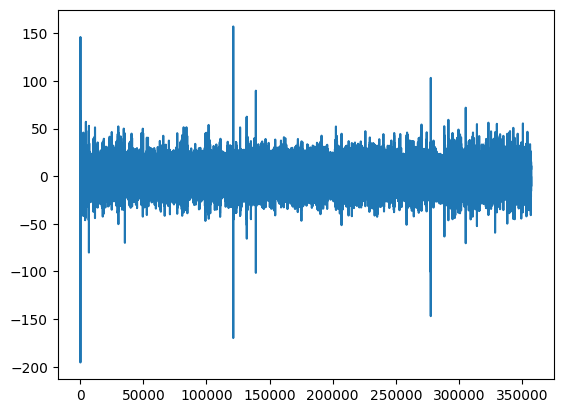

In [22]:
plt.plot(example_data[channel])

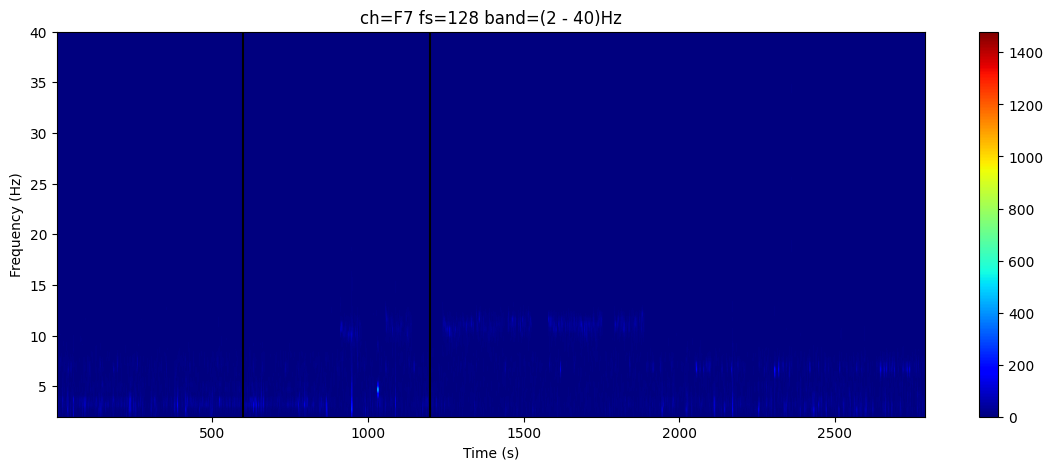

In [30]:
fft_spectogram = plot_spectrogram(example_data[channel], channel_name=channel, fs=128, fmin=2, fmax=40)

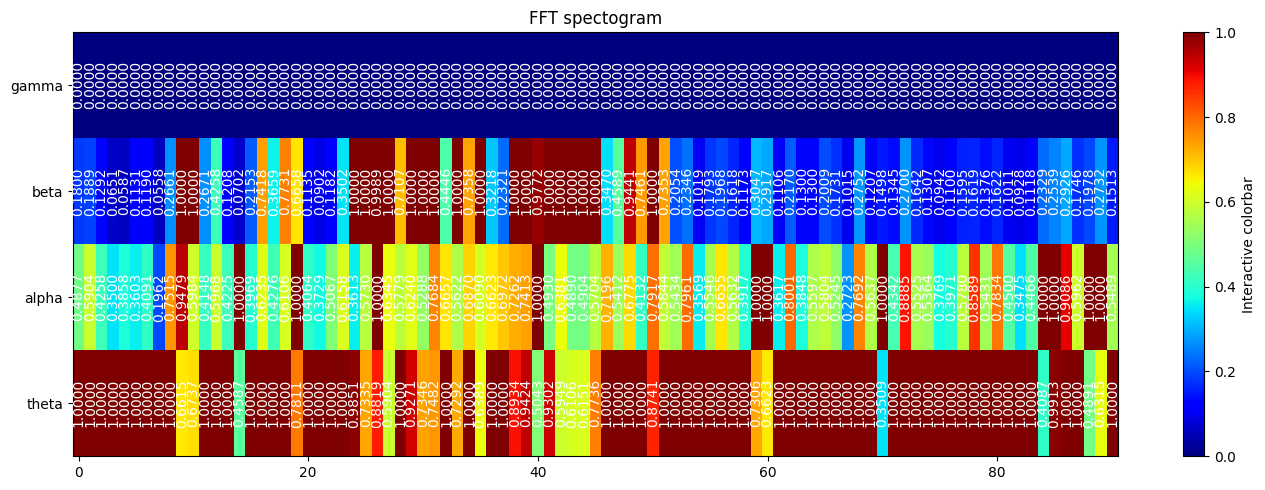

In [31]:

def plot_bins_spectogram(data, fs, channels, bins):
    # plot the spectrogram
    fig, ax = plt.subplots(figsize=(14, 5))
    Sxx, freqs, _, _ = ax.specgram(
        data,
        # NFFT=2048*4,
        Fs=fs,
        # noverlap=1024,
        cmap='jet',
    )
    Sxx = Sxx[:63, :]
    bin_sxx = np.zeros((4, bins))
    window = len(Sxx[0])//bins

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(channels.values()):
        for i in range(bins):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window]) / (f_max - f_min)
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:]) / (f_max - f_min)

    bin_sxx = bin_sxx[:, len(bin_sxx[0])//4:]

    bin_sxx = normalize_columns(bin_sxx)

    # if not plot:
    #     return bin_sxx

    im = ax.imshow(
        bin_sxx,
        cmap='jet',
        aspect='auto',
        origin='lower',
        vmin=np.min(bin_sxx),
        vmax=np.max(bin_sxx),
        )
    ax.set_yticks(np.arange(len(channels)), labels=channels.keys())

    # Loop over data dimensions and create text annotations.
    for i, _ in enumerate(channels):
        for j, _ in enumerate(bin_sxx[i]):
            text = ax.text(j, i, f'{bin_sxx[i, j]:.4f}',
                           rotation=90,
                           ha="center", va="center", color="white")

    ax.set_title("FFT spectogram")
    fig.tight_layout()
    fig.colorbar(im, ax=ax, label='Interactive colorbar')
    plt.show()
    return bin_sxx



def fft_spectogram2bins(Sxx, bins):
    bin_sxx = np.zeros((4, bins))
    window = len(Sxx[0])//bins

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(channels.values()):
        for i in range(bins):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window]) / (f_max - f_min)
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:]) / (f_max - f_min)

    bin_sxx = bin_sxx
    return normalize_columns(bin_sxx)


channels = {
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 32),
    'gamma': (32, 60),
}
_ = plot_bins_spectogram(example_data[channel], fs=128, channels=channels, bins=bins)

In [32]:
experiment_time = len(example_data[channel])/128
for window in [200_000, 100_000, 50_000, 25_000, 12_500, 6_250]:

    eeg_bands = spikes_data2eeg_bands(all_spikes2bins(example_spikes_channel, window=window))
    spikes_spectogram = spikes_dict2spectogram(eeg_bands)
    bins=int(spikes_spectogram.shape[1])
    fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, bins)

    fft_bin_spectogram = fft_bin_spectogram[:, int(len(fft_bin_spectogram)/4):]
    spikes_spectogram = spikes_spectogram[:, int(len(spikes_spectogram)/4):]

    fft_window = len(fft_spectogram[0]) / len(fft_bin_spectogram[0])
    spikes_window = len(spikes_spectogram[0]) / len(example_spikes_channel['08.000'])

    # Define two matrices
    matrix1 = fft_bin_spectogram
    matrix2 = spikes_spectogram

    # Flatten the matrices and calculate the correlation coefficient
    correlation_coefficient = np.corrcoef(matrix1.flatten(), matrix2.flatten())[0, 1]
    print(f"bins={bins} | time_window={experiment_time/bins:.3f}s | Corr={correlation_coefficient:.3f}")


bins=118 | time_window=23.651s | Corr=-0.040
bins=235 | time_window=11.876s | Corr=-0.124
bins=470 | time_window=5.938s | Corr=-0.140
bins=940 | time_window=2.969s | Corr=-0.010
bins=1879 | time_window=1.485s | Corr=-0.145
bins=3758 | time_window=0.743s | Corr=0.001
